In [1]:
import numpy as np
import matplotlib.pyplot as plt
import multiprocess as mp
import glob
import time
from tqdm import tqdm
import os
import sys
import pandas as pd
from eumap.misc import find_files
from eumap.raster import read_rasters, save_rasters
from eumap.mapper import SpaceOverlay
import geopandas as gpd
from pathlib import Path
import rasterio
import pyproj
from shapely.geometry import Point
from eumap.mapper import LandMapper

import warnings

import matplotlib
import matplotlib.pyplot as plt

from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import train_test_split, cross_val_score, HalvingGridSearchCV, KFold, GroupKFold
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_selection import RFECV, RFE
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import StackingRegressor

import joblib
import pickle

In [2]:
df = pd.read_csv('/mnt/primus/xuemeng_tmp_harbour/soc_eu/data/train_v1.csv',low_memory=False)
print(len(df))
df = df.drop(df.loc[df['oc']=='<6'].index) # 231
print(len(df))
df = df.drop(df.loc[df['oc']=='< LOD'].index)  # 33, lucas 2018
print(len(df))
df = df.drop(df.loc[df['oc']=='<0.0'].index)  # 2, lucas 2018
print(len(df))
df['oc'] = pd.to_numeric(df['oc'], errors='coerce')
df = df.drop(df.loc[df['oc']<0].index)
print(len(df))

120822
120591
120560
120558
120543


In [3]:
feat_cols = df.columns.values.tolist()
rm_list = ['gps_lat','gps_long','time','ref','country','oc','point_index']
for i in rm_list:
    feat_cols.remove(i)

df['oc_log'] = np.log1p(df['oc'].values)
df = df.reset_index(drop=True)
tgt_col = ['oc_log']

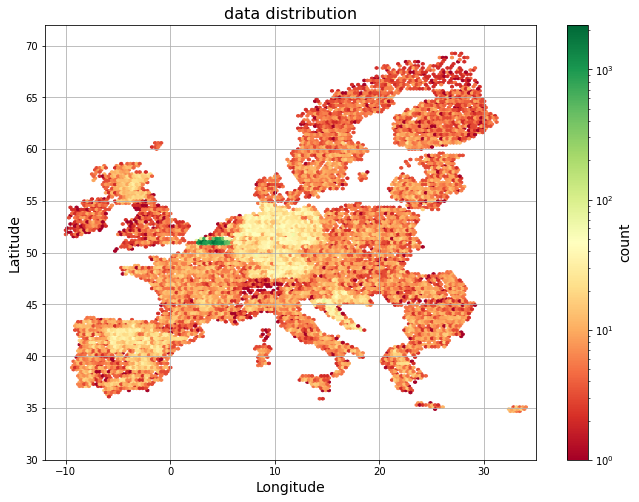

In [4]:
import matplotlib.colors as mcolors
fig, ax = plt.subplots(figsize=(11, 8))
hexbin = ax.hexbin(df['gps_long'], df['gps_lat'], gridsize=150, cmap='RdYlGn', mincnt=1, norm=mcolors.LogNorm())
ax.set_xlabel('Longitude', fontsize=14)
ax.set_ylabel('Latitude', fontsize=14)
ax.set_title(f'data distribution', fontsize=16)

ax.set_ylim([30,72])
ax.set_xlim([-12,35])
# ax.set_xlim([2,6])
# ax.set_ylim([50,52])
# hexbin.set_clim(vmin=-1, vmax=1)
# ax.legend(fontsize=14)
colorbar = plt.colorbar(hexbin)
colorbar.set_label(f'count', fontsize=14)

plt.grid(True)
plt.show()

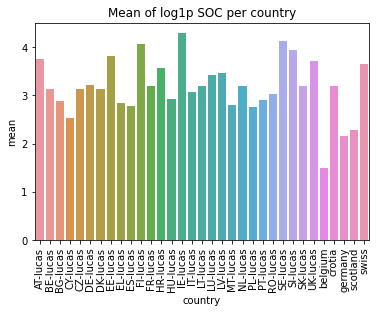

In [5]:
column_stats = df.groupby('country')['oc_log'].describe()
import matplotlib.pyplot as plt
import seaborn as sns

sns.barplot(x=column_stats.index, y=column_stats['mean'])
plt.xticks(rotation=90)
plt.title('Mean of log1p SOC per country')
plt.show()

In [6]:
grouped = df.groupby('country').size().reset_index(name='count').sort_values(by='count',ascending=False)
group = grouped.loc[grouped['count']>2500]['country'].values.tolist()
group.remove('belgium')

df['group_id'] = df['country']
df['group_id'] = df.apply(lambda x: x['country']+'_'+str(int(x['gps_long']*4))+','+str(int(x['gps_lat']*4)) if x['country']=='belgium' else x['group_id'],axis=1)
df['group_id'] = df.apply(lambda x: x['country']+'_'+str(int(x['gps_long']))+','+str(int(x['gps_lat'])) if x['country'] in group else x['group_id'],axis=1)
# grouped = dff.groupby('coor_index').size().reset_index(name='Count').sort_values(by='Count',ascending=False)
# grouped.head(20)
groupt = df.groupby('group_id').size().reset_index(name='count').sort_values(by='count',ascending=False)
print(f'{len(groupt)} groups')


696 groups


In [7]:
# merge (very small size) possible classes
ldf = groupt.loc[groupt['count']<80]['group_id'].values.tolist()
df['group_id'] = df.apply(lambda x: x['group_id'].split('_')[0] if x['group_id'] in ldf else x['group_id'],axis=1)
groupt = df.groupby('group_id').size().reset_index(name='count').sort_values(by='count',ascending=False)
print(f'{len(groupt)} groups')


383 groups


In [8]:
# x_slc, x_test, y_slc, y_test = train_test_split(dff[feat_cols], dff[tgt_col], test_size=0.6, random_state=1)
df_slc, df_test = train_test_split(df, test_size=0.7, random_state=42)
cv, groups = GroupKFold(5), df_slc['group_id']

names = ['score_mean','optimal_feature_number','feature_importance']
dfe = pd.DataFrame(columns=names)


In [11]:
feat_cols

['hzn_top',
 'hzn_btm',
 'elev.lowestmode_gedi.eml_mf_30m_s_20000101_20181231',
 'elevation_aw3d30.dsm_m_30m_s_20180101_20181231',
 'slope.pct_copernicus.glo.fabdem.dtm_m_30m_s_20100101_20151231',
 'slope_merit.dem_m_250m_s_20170101_20171231',
 'upslope.curvature_merit.dem_m_250m_s_20170101_20171231',
 'downlslope.curvature_merit.dem_m_250m_s_20170101_20171231',
 'easthness_merit.dem_m_250m_s_20180101_20181231',
 'northness_merit.dem_m_250m_s_20180101_20181231',
 'evi_mod13q1.v061_p50_250m_s_{year}0201_{year}0228',
 'evi_mod13q1.v061_sd_250m_s_{year}0201_{year}0228',
 'evi_mod13q1.v061_p50_250m_s_{year}0301_{year}0331',
 'evi_mod13q1.v061_sd_250m_s_{year}0301_{year}0331',
 'evi_mod13q1.v061_p50_250m_s_{year}0401_{year}0430',
 'evi_mod13q1.v061_sd_250m_s_{year}0401_{year}0430',
 'evi_mod13q1.v061_p50_250m_s_{year}0501_{year}0531',
 'evi_mod13q1.v061_sd_250m_s_{year}0501_{year}0531',
 'evi_mod13q1.v061_p50_250m_s_{year}0601_{year}0630',
 'evi_mod13q1.v061_sd_250m_s_{year}0601_{year}0630'

In [9]:
grid_score_mean = []
opti_feat_num = []
grid_feat_import = []
grid_feat = []

warnings.filterwarnings('ignore')
for i in [1,2,3,4]:
    rfecv = RFECV(estimator=RandomForestRegressor(200, n_jobs=50, random_state=i), cv=cv, step=10, 
                  min_features_to_select=30, n_jobs=1, scoring='neg_mean_squared_error', verbose=1)
    rfecv.fit(df_slc[feat_cols], df_slc[tgt_col].values, groups=groups)
    
    grid_score_mean += rfecv.grid_scores_
    # grid_score_std += [rfecv.cv_results_["std_test_score"]]
    opti_feat_num.append(rfecv.n_features_)
    grid_feat_import.append(rfecv.estimator_.feature_importances_)
    
    dfe.loc[len(dfe)]=[rfecv.grid_scores_,rfecv.n_features_,rfecv.estimator_.feature_importances_]
    dfe.to_csv('/mnt/apollo/bare_soil_xuemeng/evaluation_matrix_log.csv')
    
    selected_feature_indices = np.where(rfecv.support_)[0]
    selected_features = [feat_cols[i] for i in selected_feature_indices]
    grid_feat.append(selected_features)
    print(f'round {i} finished')

Fitting estimator with 825 features.



KeyboardInterrupt



In [46]:
def convert(input_str):
    cleaned_str = input_str.replace('\n', '')#.replace(' ', '')
    # real_list = ast.literal_eval(cleaned_str)
    real_list = [float(x) for x in cleaned_str[1:-1].split(' ') if x]
    # real_list.remove('')
    return real_list

In [48]:
for i in ['score_mean', 'score_std', 'feature_importance']:
    dfe[i] = dfe[i].apply(lambda x: convert(x))

In [51]:
# import ast
# mean = []
# for column in ['score_mean', 'score_std']:
#     temp = []
#     for index, row in dfe.iterrows():
#         temp.append(row[column])
# #     print(column,temp)
#     temp = np.array(temp)
#     mean.append(np.mean(temp,axis=0))

mean.append(np.nan)
dfe.loc[len(dfe)] = mean
dfe['trial'] = ['trial-0','trial-1','trial-2','trial-3','trial-4','trial-mean']

In [19]:
dfe = pd.read_csv('/mnt/primus/xuemeng_tmp_harbour/soc_eu/evaluation_matrix_log.csv',low_memory=False)
dfe = dfe.loc[:, ~dfe.columns.str.contains('^Unnamed')]

In [53]:
dfe.to_csv('/mnt/primus/xuemeng_tmp_harbour/soc_eu/evaluation_matrix_log.csv')

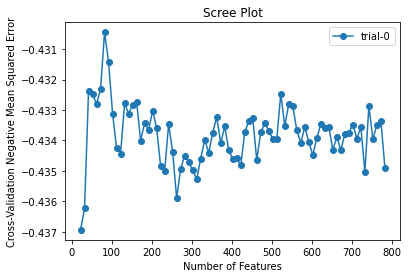

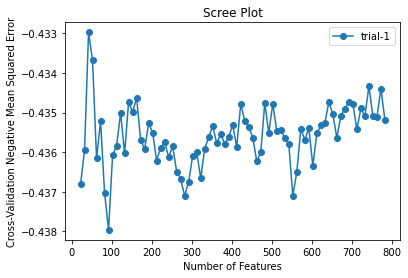

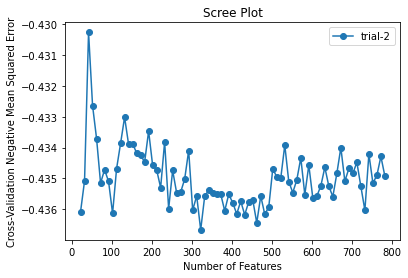

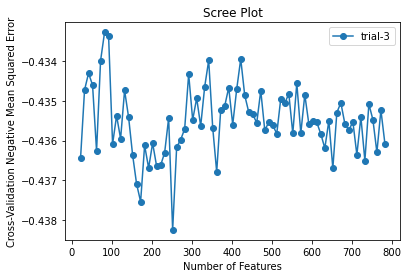

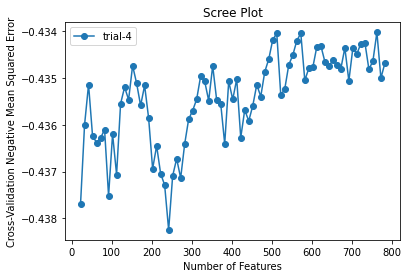

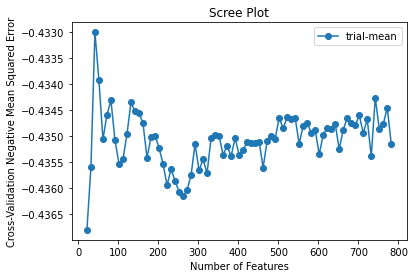

In [54]:
featn = np.arange(782,20,-10)
featn = featn[::-1]

for index, row in dfe.iterrows():
    plt.plot(featn,row['score_mean'], marker='o',label=row['trial'])
#     plt.errorbar(featn,grid_score_mean[i],grid_score_std[i],label=f'trial-{i}')
#     plt.ylim(-2.1,-1.6)
    plt.xlabel('Number of Features')
    plt.ylabel('Cross-Validation Negative Mean Squared Error')
    plt.title(f'Scree Plot')
    plt.legend()
    plt.show()

In [76]:
num_feat = featn[np.argmax(dfe.loc[5,'score_mean'])]

In [79]:
groups

41123     ES-lucas
85826     IT-lucas
53857     SI-lucas
102232     germany
6343       belgium
            ...   
110268    LU-lucas
119879    BG-lucas
103694    ES-lucas
860       scotland
15795      belgium
Name: country, Length: 36431, dtype: object

In [83]:
rfe = RFE(estimator=RandomForestRegressor(200, n_jobs=60, random_state=0), step=20, n_features_to_select=num_feat, verbose=1)
rfe.fit(df_slc[feat_cols], df_slc[tgt_col].values)


Fitting estimator with 782 features.
Fitting estimator with 762 features.
Fitting estimator with 742 features.
Fitting estimator with 722 features.
Fitting estimator with 702 features.
Fitting estimator with 682 features.
Fitting estimator with 662 features.
Fitting estimator with 642 features.


RFE(estimator=RandomForestRegressor(n_estimators=200, n_jobs=60,
                                    random_state=0),
    n_features_to_select=622, step=20, verbose=1)

In [84]:
result = list(np.array(feat_cols)[rfe.support_])

In [87]:
result

['hzn_top',
 'hzn_bottom',
 'upslope.curvature_merit.dem_m_250m_s_20170101_20171231',
 'slope_merit.dem_m_250m_s_20170101_20171231',
 'dtm_surface.lithology_egdi.1m.clay_p_250m_2018',
 'dtm_surface.lithology_egdi.1m.clasticsediment_p_250m_2018',
 'northness_merit.dem_m_250m_s_20180101_20181231',
 'easthness_merit.dem_m_250m_s_20180101_20181231',
 'downlslope.curvature_merit.dem_m_250m_s_20170101_20171231',
 'dtm_surface.lithology_egdi.1m.peat_p_250m_2018',
 'elevation_aw3d30.dsm_m_30m_s_20180101_20181231',
 'elev.lowestmode_gedi.eml_mf_30m_s_20000101_20181231',
 'slope.pct_copernicus.glo.fabdem.dtm_m_30m_s_20100101_20151231',
 'evi_mod13q1.v061.trend.logit.ols.alpha_pv_250m_s_20000101_20211231',
 'evi_mod13q1.m08.log_p75_250m_s_20000101_20211231',
 'evi_mod13q1.m04.log_p25_250m_s_20000101_20211231',
 'evi_mod13q1.m06.log_p75_250m_s_20000101_20211231',
 'evi_mod13q1.m06.log_p50_250m_s_20000101_20211231',
 'evi_mod13q1.m04.log_p75_250m_s_20000101_20211231',
 'evi_mod13q1.m08.log_p25_250m

In [86]:
omit = list(np.array(feat_cols)[~rfe.support_])
omit

['dtm_surface.lithology_egdi.1m.alkaliolivinebasalt_p_250m_2018',
 'dtm_surface.lithology_egdi.1m.arenite_p_250m_2018',
 'dtm_surface.lithology_egdi.1m.amphibolite_p_250m_2018',
 'dtm_surface.lithology_egdi.1m.andesite_p_250m_2018',
 'dtm_surface.lithology_egdi.1m.biogenicsilicasedimentaryrock_p_250m_2018',
 'dtm_surface.lithology_egdi.1m.carbonatite_p_250m_2018',
 'dtm_surface.lithology_egdi.1m.clasticsedimentarymaterial_p_250m_2018',
 'dtm_surface.lithology_egdi.1m.breccia_p_250m_2018',
 'dtm_surface.lithology_egdi.1m.chalk_p_250m_2018',
 'dtm_surface.lithology_egdi.1m.ashtufflapillistoneandlapillituff_p_250m_2018',
 'dtm_surface.lithology_egdi.1m.ashbrecciabomborblocktephra_p_250m_2018',
 'dtm_surface.lithology_egdi.1m.basanite_p_250m_2018',
 'dtm_surface.lithology_egdi.1m.brecciagougeseries_p_250m_2018',
 'dtm_surface.lithology_egdi.1m.basalt_p_250m_2018',
 'dtm_surface.lithology_egdi.1m.chloriteactinoliteepidotemetamorphicrock_p_250m_2018',
 'dtm_surface.lithology_egdi.1m.carbonat

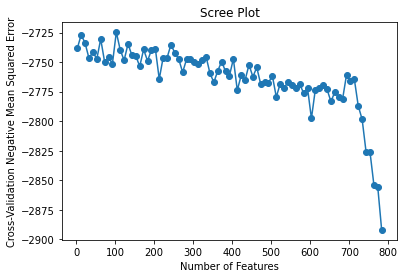

In [83]:
# Set up cross-validation
score = pd.DataFrame()
score['feat_num'] = np.arange(len(feat_cols)+1,1,-10)
score['score'] = rfecv.cv_results_['mean_test_score']

plt.plot(score['feat_num'], score['score'], marker='o')
plt.xlabel('Number of Features')
plt.ylabel('Cross-Validation Negative Mean Squared Error')
plt.title(f'Scree Plot')
plt.show()

best_feature_index = score['score'].idxmax()
best = score.iloc[best_feature_index]['feat_num']

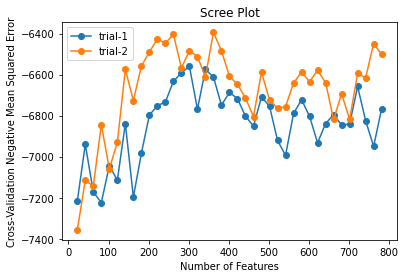

In [41]:
with open('/mnt/inca/soc_eu_model/feature_selection/test.txt', 'w') as file:
    for item in grid_scores:
        file.write(str(item) + '\n')
        
list_strings = data_string.strip("[]").split("],")

# Convert each list string to an actual list
lists = [ast.literal_eval(s.strip()) for s in list_strings]

file_path = "/mnt/inca/soc_eu_model/feature_selection/test.txt"  # Replace with the path to your text file
lines = []
with open(file_path, "r") as file:
    for line in file:
        lines.append(line.strip())
        
line = ''
for i in range(len(lines)):
    line = line+lines[i]
line1 = line.split('][')[0][1::]
line2 = line.split('][')[1][0:-1]

import re
numl1 = [num for num in re.split(r'[-\s]+', line1)]
numl1 = [float(num)*(-1) for num in numl1 if num != '']

numl2 = [num for num in re.split(r'[-\s]+', line2)]
numl2 = [float(num)*(-1) for num in numl2 if num != '']

plt.plot(featn,numl1, marker='o',label='trial-1')
plt.plot(featn,numl2, marker='o',label='trial-2')
plt.xlabel('Number of Features')
plt.ylabel('Cross-Validation Negative Mean Squared Error')
plt.title(f'Scree Plot')
plt.legend()
plt.show()

# best_feature_index = score['score'].idxmax()
# best = score.iloc[best_feature_index]['feat_num']

In [ ]:
from sklearn.model_selection import GroupKFold, KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFECV, RFE
from scipy.signal import argrelmin
import joblib

def run_feature_selection(data, covs, target_column, spatial_cv_column = None, 
                          subsample_pct = 0.1, n_rep = 5, n_cv = 5, ntrees = 50, local_min_pos = 1):

    rfecv_step = int(len(covs) * 0.1)
    rfe_step = int(rfecv_step / 2)
    

    cv, groups = KFold(n_cv), None
    if spatial_cv_column is not None:
        cv, groups = GroupKFold(n_cv), data[spatial_cv_column]

    ncpu = multiprocessing.cpu_count()
    if ntrees < ncpu:
        ncpu = ntrees

    ttprint(f"Finding n_features_to_select using RFECV (repetitions={n_rep} step={rfecv_step})")
    
    grid_scores = []
    for i in range(0,n_rep):
        rfecv = RFECV(estimator=RandomForestRegressor(ntrees, n_jobs=ncpu, random_state=i), cv=cv, step=rfecv_step, 
            min_features_to_select=10, n_jobs=n_cv, scoring=scoring, verbose=1)
        rfecv.fit(data[covs], data[target_column], groups=groups)
        grid_scores += [rfecv.cv_results_['mean_test_score']]

    rfecv_mean_score = np.mean(np.stack(grid_scores, axis=0), axis=0)
    grid_scores_std = np.std(np.stack(grid_scores, axis=0), axis=0)

    rfecv_n_features_arr = list(range(rfecv.min_features_to_select, len(covs)+rfecv.step, rfecv.step))

    local_min_arr = argrelmin(rfecv_mean_score, order=1)[0]
    local_min = local_min_arr[0]
    if len(local_min_arr) > 1:
        local_min = local_min_arr[local_min_pos]

    n_features_to_select = rfecv_n_features_arr[local_min]

    ttprint(f"Finding best features using RFE (n_features_to_select = {n_features_to_select})")

    rfe = RFE(estimator=RandomForestRegressor(ntrees, n_jobs=ncpu, random_state=n_rep), step=rfe_step, n_features_to_select=n_features_to_select, verbose=1)
    rfe.fit(data[covs], data[target_column])

    result = list(np.array(covs)[rfe.support_])
    
    return result, rfecv_n_features_arr, rfecv_mean_score, grid_scores_std

fn_rfcv = Path(f'model_{target_col}_v1.1_rfecv.lz4', compress='lz4')
if Path(fn_rfcv).exists():
    locals().update(joblib.load(fn_rfcv))
else:
    print("Executing")
    covs_rfe, rfecv_n_features_arr, rfecv_mean_score, rfecv_std_score = run_feature_selection(data=samples, covs=feat_cols, target_column=target_col, spatial_cv_column=cv_group_col, ntrees=60, local_min_pos=1)
    joblib.dump({
        'covs_rfe':covs_rfe, 
        'rfecv_n_features_arr': rfecv_n_features_arr, 
        'rfecv_mean_score': rfecv_mean_score,
        'rfecv_std_score': rfecv_std_score
    }, fn_rfcv)

#covs_rfe, rfecv_n_features_arr, rfecv_mean_score, rfecv_std_score = run_feature_selection(data=samples, covs=feat_cols, target_column=target_col, spatial_cv_column=cv_group_col)

In [88]:
%history

import numpy as np
import matplotlib.pyplot as plt
import multiprocess as mp
import glob
import time
from tqdm import tqdm
import os
import sys
import pandas as pd
from eumap.misc import find_files
from eumap.raster import read_rasters, save_rasters
from eumap.mapper import SpaceOverlay
import geopandas as gpd
from pathlib import Path
import rasterio
import pyproj
from shapely.geometry import Point
from eumap.mapper import LandMapper

import warnings

import matplotlib
import matplotlib.pyplot as plt

from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import train_test_split, cross_val_score, HalvingGridSearchCV, KFold, GroupKFold
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.neural_network impo